In [2]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [4]:
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1]))
        self.activation = nn.Tanh()

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation(layer(x))
        return self.layers[-1](x)        

In [5]:
def physics_loss(model, x, f):
    x = x.requires_grad_(True)
    u = model(x)
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    residual = -u_xx - f(x)
    return torch.mean(residual**2)

def boundary_loss(model, x_boundary, u_boundary):
    u_pred = model(x_boundary)
    return torch.mean((u_pred - u_boundary)**2)

In [6]:
def train_pinn(model, optimizer, x_collocation, x_boundary, u_boundary, f, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss_physics = physics_loss(model, x_collocation, f)
        loss_boundary = boundary_loss(model, x_boundary, u_boundary)

        loss = loss_physics + loss_boundary
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


def exact_solution(x):
    return (1 / (np.pi**2)) * np.sin(np.pi * x)

c:\Users\alexa\miniconda3\envs\pinn\Lib\site-packages\torch\autograd\graph.py:825: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11070). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0, Loss: 0.518539
Epoch 100, Loss: 0.000860
Epoch 200, Loss: 0.000476
Epoch 300, Loss: 0.000214
Epoch 400, Loss: 0.000039
Epoch 500, Loss: 0.000010
Epoch 600, Loss: 0.000029
Epoch 700, Loss: 0.000008
Epoch 800, Loss: 0.000008
Epoch 900, Loss: 0.000008
Epoch 1000, Loss: 0.000690
Epoch 1100, Loss: 0.000007
Epoch 1200, Loss: 0.000007
Epoch 1300, Loss: 0.000008
Epoch 1400, Loss: 0.000007
Epoch 1500, Loss: 0.000118
Epoch 1600, Loss: 0.000007
Epoch 1700, Loss: 0.000007
Epoch 1800, Loss: 0.000013
Epoch 1900, Loss: 0.000007
Epoch 2000, Loss: 0.001023
Epoch 2100, Loss: 0.000007
Epoch 2200, Loss: 0.000007
Epoch 2300, Loss: 0.000241
Epoch 2400, Loss: 0.000007
Epoch 2500, Loss: 0.000243
Epoch 2600, Loss: 0.000007
Epoch 2700, Loss: 0.000007
Epoch 2800, Loss: 0.000734
Epoch 2900, Loss: 0.000007
Epoch 3000, Loss: 0.000007
Epoch 3100, Loss: 0.000007
Epoch 3200, Loss: 0.000007
Epoch 3300, Loss: 0.000104
Epoch 3400, Loss: 0.000007
Epoch 3500, Loss: 0.000007
Epoch 3600, Loss: 0.000007
Epoch 3700, L

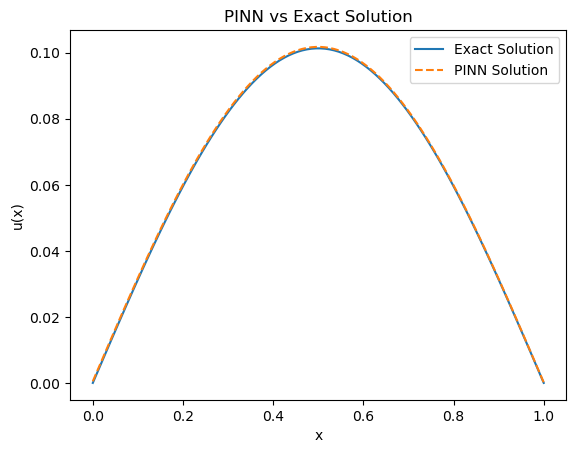

In [7]:
x_collocation = torch.linspace(0, 1, 100).view(-1, 1)
x_boundary = torch.tensor([[0.0], [1.0]])
u_boundary = torch.tensor([[0.0], [0.0]])

# Source term
f = lambda x: torch.sin(np.pi * x)

# Create the PINN model
layers = [1, 20, 20, 1]  # Input layer, hidden layers, output layer
model = PINN(layers)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the PINN
train_pinn(model, optimizer, x_collocation, x_boundary, u_boundary, f, epochs=5000)

# Evaluate the model
x_test = torch.linspace(0, 1, 100).view(-1, 1)
u_pred = model(x_test).detach().numpy()
u_exact = exact_solution(x_test.numpy())

# Plot the results
plt.plot(x_test.numpy(), u_exact, label="Exact Solution")
plt.plot(x_test.numpy(), u_pred, label="PINN Solution", linestyle="dashed")
plt.legend()
plt.xlabel("x")
plt.ylabel("u(x)")
plt.title("PINN vs Exact Solution")
plt.show()